# Import Library

In [2]:
# !pip install dlib imutils

In [3]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps
import cv2
import dlib
from imutils import face_utils
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

/tmp/ipykernel_25400/3617764464.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-01-23 04:08:55.437028: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 04:08:55.491671: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 04:08:55.491718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin

# Read data

In [4]:
images = []
ages = []
genders = []

for i in os.listdir('../input/utkface-new/UTKFace/'):
# for i in os.listdir('../input/utkface-new/UTKFace/')[0:100]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('../input/utkface-new/UTKFace/' + i))
images = np.stack(images)
    
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df

,Images,Ages,Genders
0,"[[[167, 158, 153], [167, 158, 153], [167, 158,...",28,0
1,"[[[180, 168, 170], [178, 166, 168], [176, 164,...",21,1
2,"[[[5, 6, 0], [4, 5, 0], [3, 4, 0], [2, 3, 0], ...",26,1
3,"[[[43, 19, 17], [45, 21, 19], [45, 24, 21], [4...",43,0
4,"[[[13, 9, 23], [14, 10, 24], [15, 11, 25], [16...",36,0
...,...,...,...
95,"[[[1, 3, 15], [1, 3, 15], [1, 3, 16], [1, 3, 1...",17,0
96,"[[[208, 205, 174], [206, 203, 172], [207, 201,...",38,1
97,"[[[63, 42, 37], [65, 44, 39], [63, 42, 37], [5...",32,0
98,"[[[61, 48, 32], [73, 60, 44], [89, 76, 60], [1...",26,0


In [5]:
# Adding my images to Dataframe
emma = {'Ages': 18, 'Genders': 1, 'Images': Image.open('../input/private-data/R.jpg')}
df.loc[-1] = emma
df.index = df.index + 1
jennifer = {'Ages': 16, 'Genders': 1, 'Images': Image.open('../input/private-data/jennifer.jpg')}
df.loc[-1] = jennifer
df.index = df.index + 1
df = df.sort_index()

## Visualising and Preparing Data

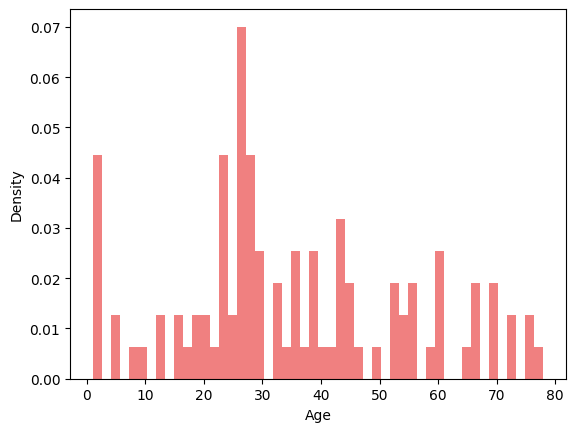

In [6]:
plt.hist(df['Ages'], bins=50, color='lightcoral', density=True)
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

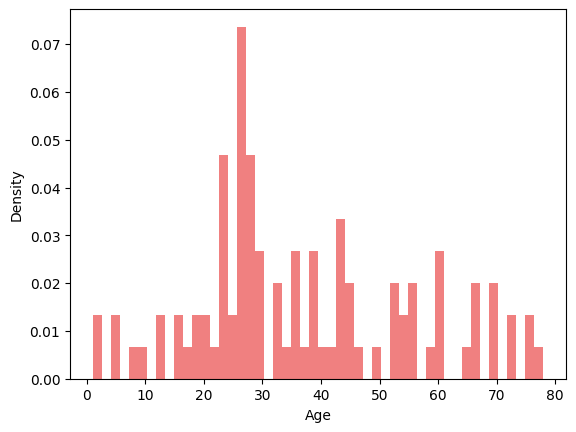

In [7]:
# Keep only 30% of data under 4 years old
# and remove data over 80 years old
under_4 = df[df['Ages'] < 4].sample(frac=0.3, random_state=2024)
between_4_and_80 = df[(df['Ages'] >= 4) & (df['Ages'] <= 80)]

df = pd.concat([under_4, between_4_and_80])
df.reset_index(drop=True)

plt.hist(df['Ages'], bins=50, color='lightcoral', density=True)
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

## Data at first sight

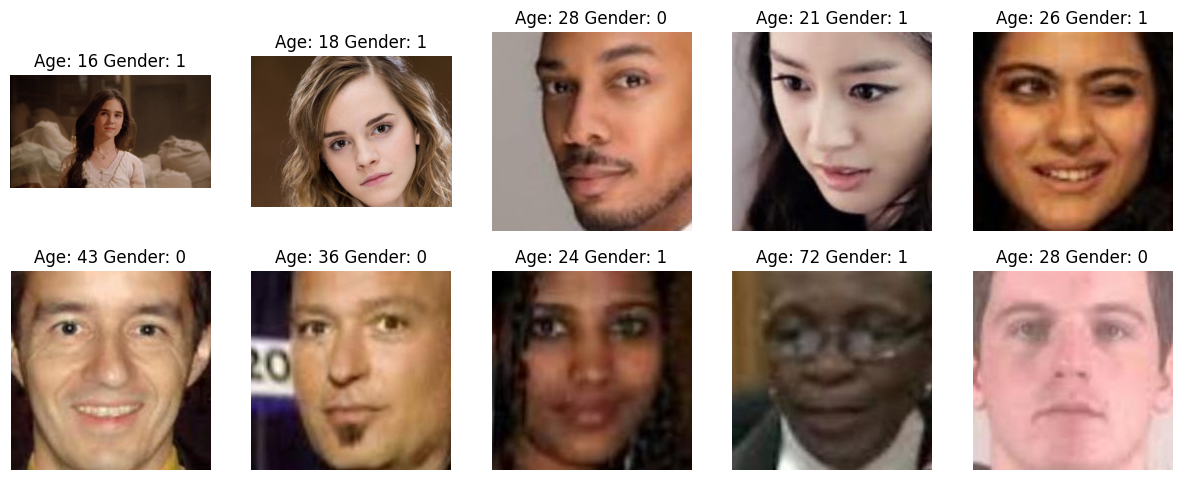

In [8]:
def show_example_images(df, src, x):
    plt.figure(figsize=(15,15))
    for i in range(0,x):
        plt.subplot(5,5, i+1)
        plt.imshow(df[src][i], cmap='gray')
        plt.title(f"Age: {df['Ages'][i]} Gender: {df['Genders'][i]}")
        plt.axis('off')
        
show_example_images(df, 'Images', 10)

# Image Preprocessing
1. **Noise Subdual**
2. **Contrast Enhancements**
3. **Face Detection and Alignment Using Landmark Localisation using the Dlib library**


### Noise Subdual:

- Task: Reduce noise in facial images.
- Method: Apply median filters to smooth out pixel-level noise.

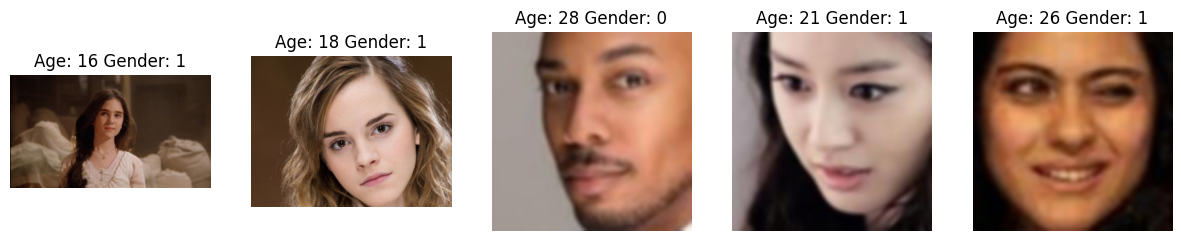

In [9]:
visual_df = df.head(50).copy()

def reduce_noise(image):
    # Convert PIL Image to NumPy array
    img_array = np.array(image)

    # Apply mean filter for noise reduction
    kernel_size = (5, 5)
    blurred_image = cv2.blur(img_array, kernel_size)

    # Convert back to PIL Image
    denoised_image = Image.fromarray(blurred_image)

    return denoised_image

visual_df['Images'] = visual_df['Images'].apply(reduce_noise)
show_example_images(visual_df, 'Images', 5)

### Contrast Enhancements:

- Task: Improve visibility and detail by adjusting contrast.
- Method: Histogram equalization to spread out pixel intensities.

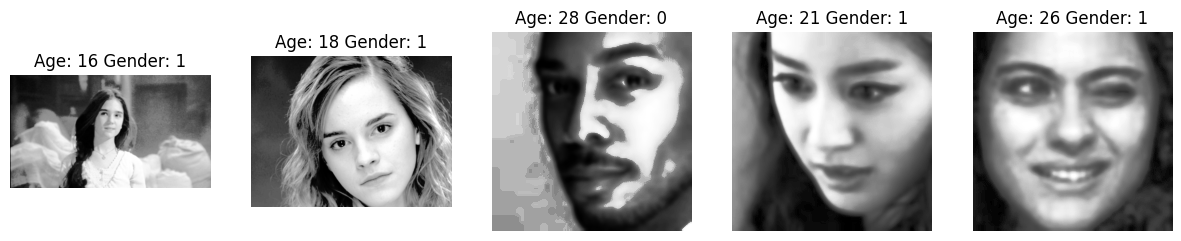

In [10]:
def enhance_contrast(image):
    # Convert PIL Image to NumPy array
    img_array = np.array(image)

    # Convert to grayscale if the image is in color
    if len(img_array.shape) == 3 and img_array.shape[2] == 3:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

    # Apply histogram equalization for contrast enhancement
    enhanced_image = cv2.equalizeHist(img_array)

    # Convert back to PIL Image
    enhanced_image = Image.fromarray(enhanced_image)

    return enhanced_image

visual_df['Images'] = visual_df['Images'].apply(enhance_contrast)
show_example_images(visual_df, 'Images', 5)

### Face Detection and Alignment Using Landmark Localisation using the Dlib library
- Tasks:
    - Detect face in images
    - Remove undetected images from Dataframe
    - Align face to the eyes horizontally
    - Crop the face to its center
    - Resize the cropped face to 110x110

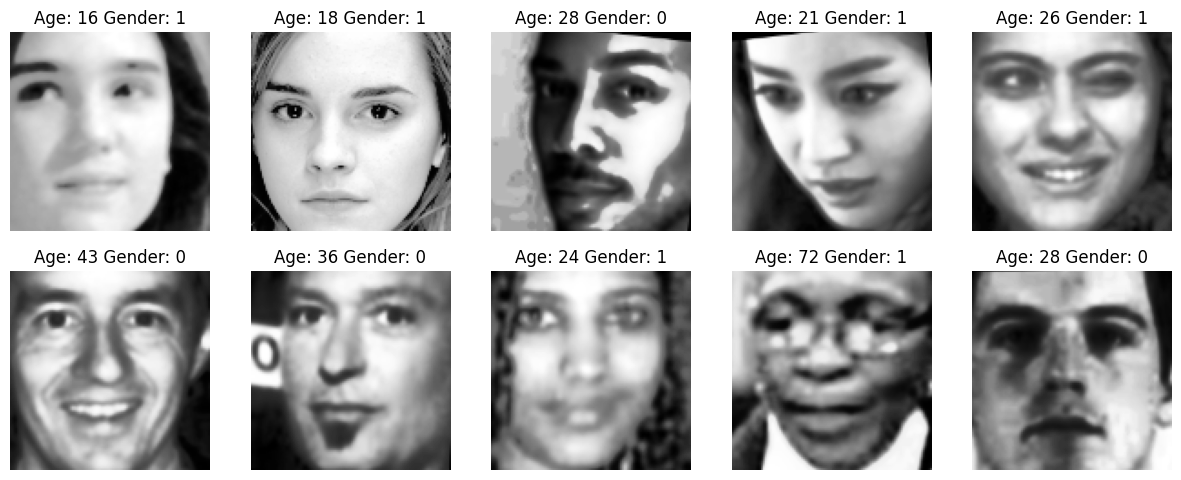

In [11]:
# Load the pre-trained face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../input/shape-predictor-68-face-landmarksdat/shape_predictor_68_face_landmarks.dat")

# Function to detect face and align the image
def detect_and_align(image):
    # Convert PIL Image to NumPy array
    image = np.array(image)
    
    # Grayscale image
    try:
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        grayscale_image = image

    # Detect faces in the image
    faces = detector(grayscale_image)
    # No face detected
    if len(faces) == 0:
        return None

    # First detected face
    face = faces[0]

    # Get the landmarks for the face in the image
    landmarks = predictor(grayscale_image, face)
    landmarks = face_utils.shape_to_np(landmarks)
    
    # Get left eye & right eye coordinates
    leftEyeX, leftEyeY = landmarks[39]
    rightEyeX, rightEyeY = landmarks[42]

    # Calculate angle of rotation & origin point
    angle = math.atan( (leftEyeY - rightEyeY) / (leftEyeX - rightEyeX) ) * (180/math.pi)
    origin_point = tuple(np.array(image.shape[1::-1]) / 2)

    # Rotate the image to align the eyes horizontally
    rotation_matrix = cv2.getRotationMatrix2D(origin_point, angle, scale=1)
    aligned_face = cv2.warpAffine(grayscale_image, rotation_matrix, (image.shape[1], image.shape[0]))

    # Crop and resize the aligned face to 110x110
    # Get the coordinates of the bounding box
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    # Calculate the center of the face
    center_x = x + w // 2
    center_y = y + h // 2
    # Calculate the size for cropping (minimum of width and height)
    crop_size = min(w, h)
    # Calculate the bounding box coordinates for cropping
    crop_x = max(center_x - crop_size // 2, 0)
    crop_y = max(center_y - crop_size // 2, 0)
    # Crop the face to its center
    cropped_face = aligned_face[crop_y:crop_y + crop_size, crop_x:crop_x + crop_size]
    # Resize the cropped face to 110x110
    resized_face = cv2.resize(cropped_face, (110, 110))

    
    # Convert back to PIL Image
    aligned_image = Image.fromarray(resized_face)

    return aligned_image

visual_df['Aligned_Images'] = visual_df['Images'].apply(detect_and_align)
# If no face detected, remove from the DataFrame
visual_df = visual_df.dropna(subset=['Aligned_Images']).sort_index()

# Visualize the results
show_example_images(visual_df, 'Aligned_Images', 10)

## Image Preprocessing
Put all the Image Preprocessing steps together (remove duplicate functions helps run faster)

In [12]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../input/shape-predictor-68-face-landmarksdat/shape_predictor_68_face_landmarks.dat")

def image_preprocessing(image):
    # Convert PIL Image to NumPy array
    image = np.array(image)
 
    # Apply mean filter for noise reduction
    kernel_size = (5, 5)
    blurred_image = cv2.blur(image, kernel_size)
    
    # Grayscale image
    try:
        grayscale_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)
    except:
        grayscale_image = blurred_image
        
    # Apply histogram equalization for contrast enhancement
    enhanced_image = cv2.equalizeHist(grayscale_image)

    # Detect faces in the image
    faces = detector(enhanced_image)
    # No face detected
    if len(faces) == 0:
        return None

    # First detected face
    face = faces[0]

    # Get the landmarks for the face in the image
    landmarks = predictor(enhanced_image, face)
    landmarks = face_utils.shape_to_np(landmarks)
    
    # Get left eye & right eye coordinates
    leftEyeX, leftEyeY = landmarks[39]
    rightEyeX, rightEyeY = landmarks[42]

    # Calculate angle of rotation & origin point
    angle = math.atan( (leftEyeY - rightEyeY) / (leftEyeX - rightEyeX) ) * (180/math.pi)
    origin_point = tuple(np.array(image.shape[1::-1]) / 2)

    # Rotate the image to align the eyes horizontally
    rotation_matrix = cv2.getRotationMatrix2D(origin_point, angle, scale=1)
    aligned_face = cv2.warpAffine(enhanced_image, rotation_matrix, (image.shape[1], image.shape[0]))

    # Crop and resize the aligned face to 110x110
    # Get the coordinates of the bounding box
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    # Calculate the center of the face
    center_x = x + w // 2
    center_y = y + h // 2
    # Calculate the size for cropping (minimum of width and height)
    crop_size = min(w, h)
    # Calculate the bounding box coordinates for cropping
    crop_x = max(center_x - crop_size // 2, 0)
    crop_y = max(center_y - crop_size // 2, 0)
    # Crop the face to its center
    cropped_face = aligned_face[crop_y:crop_y + crop_size, crop_x:crop_x + crop_size]
    # Resize the cropped face to 110x110
    resized_face = cv2.resize(cropped_face, (110, 110))

    
    # Convert back to PIL Image
    aligned_image = Image.fromarray(resized_face)

    return aligned_image

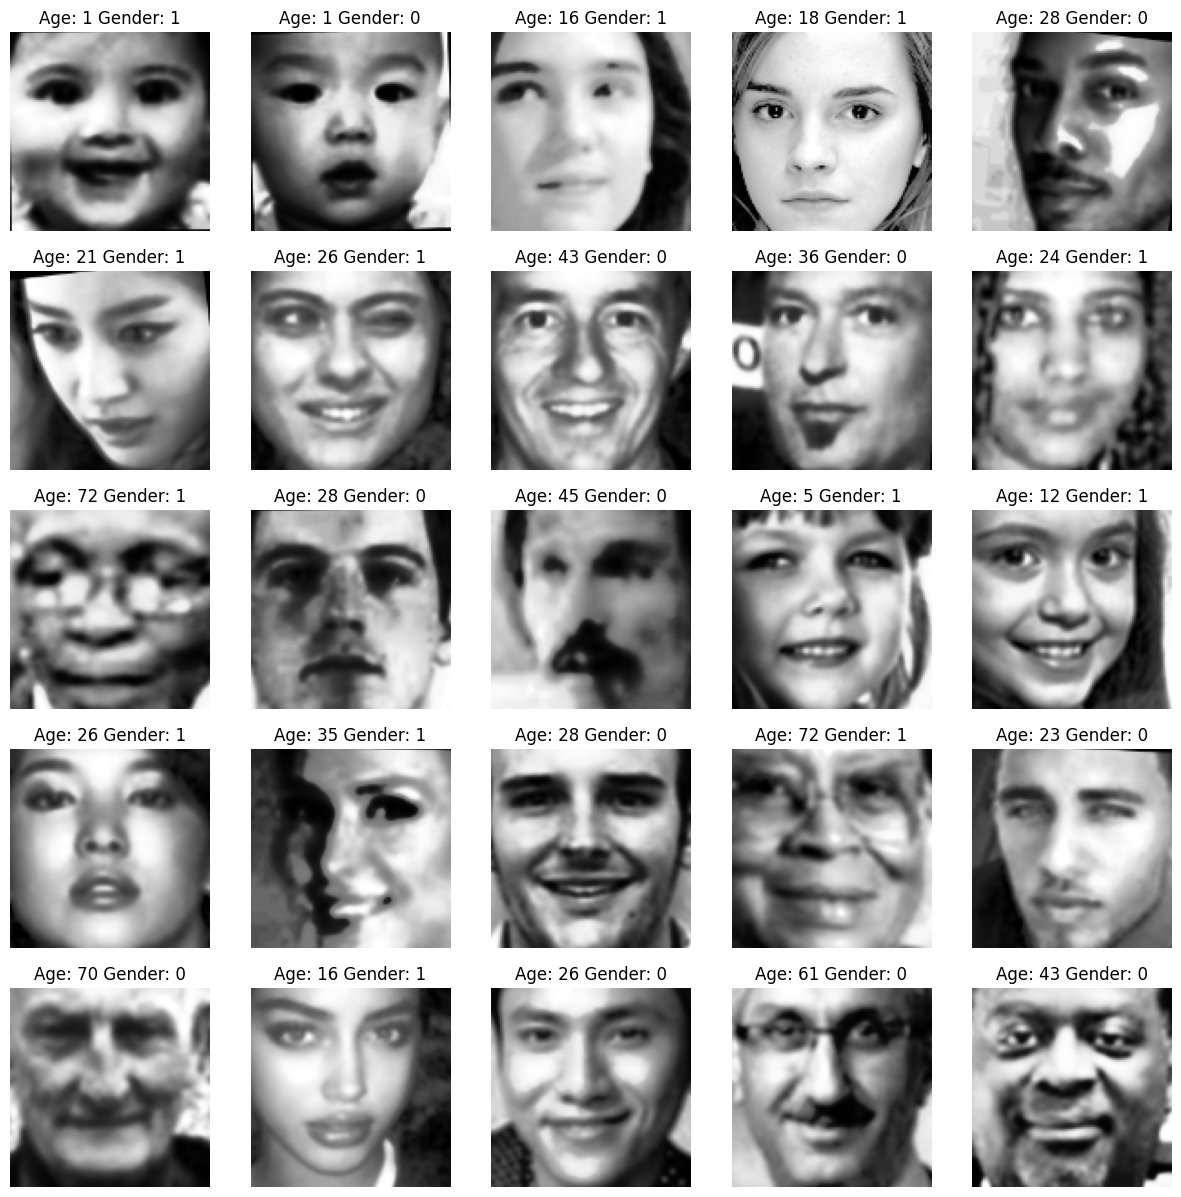

In [13]:
df['P_Images'] = df['Images'].apply(image_preprocessing)
# If no face detected, remove from the DataFrame
df = df.dropna(subset=['P_Images']).sort_index()

# Visualize the results
show_example_images(df, 'P_Images', 25)